In [ ]:
#Building a dog breeds image classification model.

#Using a deep learning neural network model to identify the breed of a dog from the image. 
#Dataset was downloaded from the kaggle website at https://www.kaggle.com/c/dog-breed-identification/data


In [12]:
#Importing libraries and packages

#Data management, analysis and visualization
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

#Image manipulation
import PIL.Image
from IPython.display import display

#Importing the Keras libraries and packages
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
#from keras.utils import np_utils
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

In [ ]:
#To get dataset from kaggle to use in google colab, refer to this blog, https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8

#from google.colab import files
#files.upload() #upload kaggle.json



Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"ranjanisabarinathan","key":"93f402a9f9536e4b41b6c77467310917"}'}

In [ ]:
#!pip install --upgrade --force-reinstall --no-deps kaggle
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp36-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
#!kaggle competitions download -c dog-breed-identification

dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#!unzip dog-breed-identification.zip

Archive:  dog-breed-identification.zip
replace labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
#Loading paths to the train and test images

train= 'dog-breed-identification/train/'
test = 'dog-breed-identification/test/'

In [4]:
#Load labels and sample submission (test)


labels = pd.read_csv('labels.csv')
testf = pd.read_csv('sample_submission.csv')



In [5]:
#Exploring the labels data

labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
labels.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [5]:
#In the labels dataframe, group by breeds to determine the number of images belonging to each breed.
breed = labels.groupby("breed").count()
breed = breed.rename(columns = {"id" : "count"})
breed = breed.sort_values("count", ascending=False)
breed.head()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


In [6]:
# Get the number of classes
labelsb = np.unique(labels.breed)
numClasses = labelsb.size
print(numClasses)


120


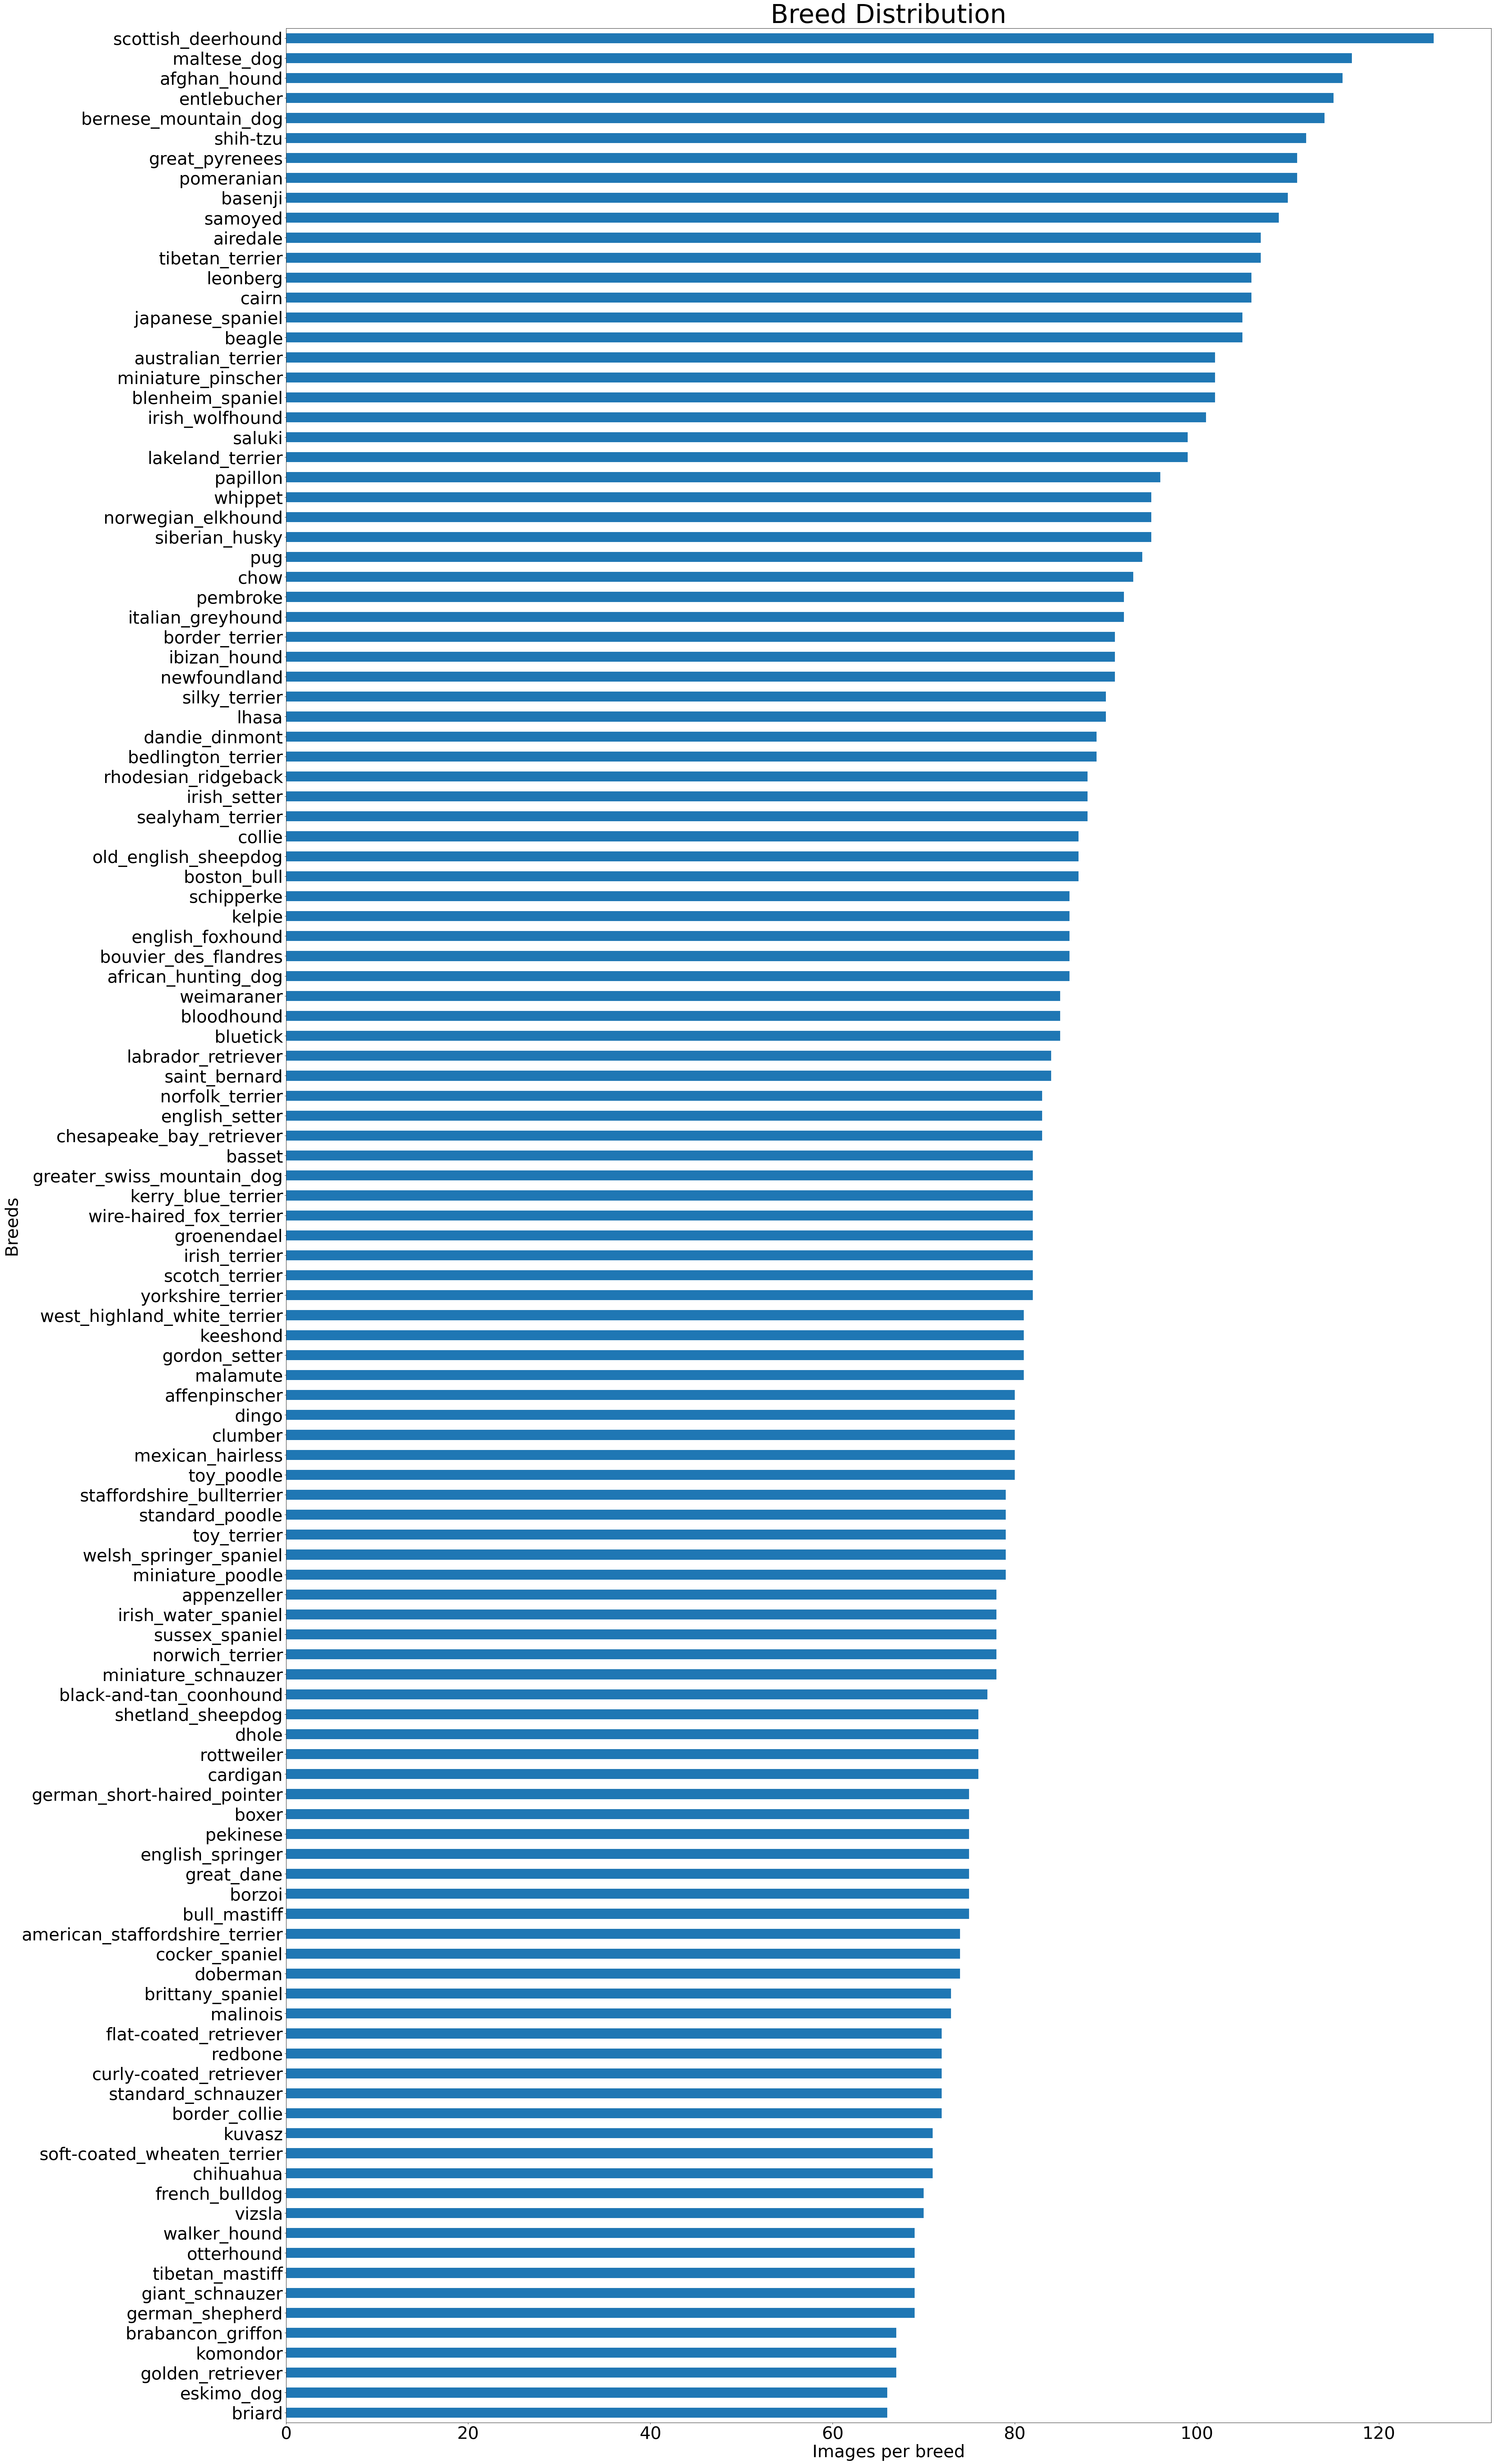

In [10]:
#Plotting distribution of the breeds

dist =pd.value_counts(labels['breed'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title= "Breed Distribution",
                                                       figsize=(50,100))
dist.set(xlabel="Images per breed", ylabel="Breeds")
dist.xaxis.label.set_size(40)
dist.yaxis.label.set_size(40)
dist.title.set_size(60)
plt.show()

In [27]:
#Select only the top 30 breeds 

breeds =list(labels.breed.value_counts()[0:30].index)
breeds

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed',
 'airedale',
 'tibetan_terrier',
 'leonberg',
 'cairn',
 'beagle',
 'japanese_spaniel',
 'australian_terrier',
 'blenheim_spaniel',
 'miniature_pinscher',
 'irish_wolfhound',
 'lakeland_terrier',
 'saluki',
 'papillon',
 'norwegian_elkhound',
 'whippet',
 'siberian_husky',
 'pug',
 'chow',
 'italian_greyhound',
 'pembroke']

In [28]:
#Create another dataframe with just the top 30 breeds 

labels30 = labels[labels.breed.isin(breeds)]
labels30.head()


,id,breed
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
12,00693b8bc2470375cc744a6391d397ec,maltese_dog
18,007ff9a78eba2aebb558afea3a51c469,lakeland_terrier
29,00bee065dcec471f26394855c5c2f3de,cairn


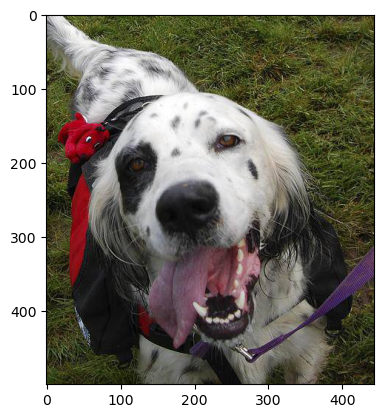

In [5]:
#Visualizing a single image using matplotlib

single_img = image.load_img('dog-breed-identification/train/00e9ed3fab1d2032603d1a90e557976f.jpg')
plt.imshow(single_img)





In [6]:
#A function that adds a third column 'path' to the labels dataframes
#Appending the path to the image in the path column.

def addColumn (data,f):
    data = data.assign(path=lambda x: f + x['id'] +'.jpg')
    return data

labels = addColumn(labels,train)

labels.head()


,id,breed,path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,dog-breed-identification/train/000bec180eb18c7...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,dog-breed-identification/train/001513dfcb2ffaf...
2,001cdf01b096e06d78e9e5112d419397,pekinese,dog-breed-identification/train/001cdf01b096e06...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,dog-breed-identification/train/00214f311d5d224...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,dog-breed-identification/train/0021f9ceb3235ef...


In [7]:
#Add another column for breed - test using binary classification
#Assign binary values 0 and 1 depending on if breed is a scottish deerhound

breedb=[]
breed = labels['breed']
for i in range(0,len(breed)):
    if breed[i]=='scottish_deerhound':
        b = 1
    else:
        b = 0
    breedb.append(b)


In [8]:
labels = labels.assign(scottish_deerhound = breedb)

In [17]:
#Predicting the entire test set

test_data = addColumn(testf,test)
test_data.head()



,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier,path
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,dog-breed-identification/test/000621fb3cbb32d8...
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,dog-breed-identification/test/00102ee9d8eb9081...
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,dog-breed-identification/test/0012a730dfa437f5...
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,dog-breed-identification/test/001510bc8570bbee...
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,dog-breed-identification/test/001a5f3114548acd...


In [18]:
#function to convert image files to numpy array

def convert_img(path):
    #path - path to the image file
    #returns image as numpy array
    img = image.load_img(path, target_size = (128,128))
    img = image.img_to_array(img)
    return img




In [16]:
#Convert train and test images into numpy arrays and resize the images

X =np.array([convert_img(img)
                    for img in labels['path'].values.tolist()])


X.shape

(10222, 128, 128, 3)

In [51]:
test_img = np.array([convert_img(img)
                   for img in test_data['path'].values.tolist()])
test_img.shape

(10357, 128, 128, 3)

In [10]:
#Applying  label encoder to the breeds column in labels breed column


labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(labels['breed'].values)
#labels_b = labels30.breed
#labels_b =pd.get_dummies(labels30.breed)
Y


array([19, 37, 85, ...,  3, 75, 28])

In [11]:
#Convert 1-dimensional class arrays to 30-dimensional class matrices for labels[breed]
Y= image.to_categorical(Y, 120)
Y.shape



(10222, 120)

In [33]:
#Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    stratify=Y)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(8177, 128, 128, 3)
(8177, 120)
(2045, 128, 128, 3)
(2045, 120)


In [34]:
#Convert data type 

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [35]:
#Data Augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                    #featurewise_center=True,
                                    #featurewise_std_normalization=True,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True
                                    )


test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen.fit(X_train)
test_datagen.fit(X_test)

training_set =  train_datagen.flow(X_train,Y_train,batch_size=32)
testing_set  =  test_datagen.flow(X_test,Y_test,batch_size=32)



In [38]:
#Creating the CNN model

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.1))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 120, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# model summmary
classifier.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 30, 30, 32)       

In [39]:
#Fitting the CNN to the images

classifier.fit(training_set,
                      
                      validation_data = testing_set,
            
                      epochs = 5,
                      verbose = 1)

Epoch 1/5
256/256 [==============================] - 73s 283ms/step - loss: 4.7923 - accuracy: 0.0121 - val_loss: 4.7612 - val_accuracy: 0.0142
Epoch 2/5
256/256 [==============================] - 82s 320ms/step - loss: 4.7261 - accuracy: 0.0155 - val_loss: 4.5954 - val_accuracy: 0.0284
Epoch 3/5
256/256 [==============================] - 100s 389ms/step - loss: 4.5829 - accuracy: 0.0273 - val_loss: 4.4444 - val_accuracy: 0.0323
Epoch 4/5
256/256 [==============================] - 96s 375ms/step - loss: 4.5092 - accuracy: 0.0341 - val_loss: 4.4505 - val_accuracy: 0.0396
Epoch 5/5
256/256 [==============================] - 85s 332ms/step - loss: 4.4583 - accuracy: 0.0382 - val_loss: 4.3983 - val_accuracy: 0.0391


In [29]:
classifier.evaluate(testing_set,verbose=1) #binary classification - is breed scottish deerhound or not?

64/64 [==============================] - 3s 40ms/step - loss: 0.0678 - accuracy: 0.9878


[0.06778239458799362, 0.9877750873565674]

In [62]:
predictions= classifier.predict(test_img)

In [ ]:
#Putting the predictions into pandas dataframe

# Set column names of the breeds from sample_submission 
submission = pd.DataFrame(predictions)
testf2 = testf.drop("id", axis=1)
submission.columns = testf2.columns.values

# Insert the column id from the sample_submission at the start of the data frame
submission.insert(0, 'id', testf['id'])
submission


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,8.542836e-36,0.000000e+00,0.000000e+00,1.256502e-32,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.714071e-33,0.000000e+00,0.0,8.047505e-29,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.696622e-11,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.414096e-35,1.908798e-29,8.940146e-30,0.0,0.0,0.000000e+00,2.876081e-35,0.000000e+00,2.207245e-36,5.308357e-35,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,2.190691e-24,5.467600e-33,8.765850e-24,3.396161e-36,5.097109e-38,2.077498e-28,0.000000e+00
1,00102ee9d8eb90812350685311fe5890,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,7.716916e-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.915810e-27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,9.692737e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,3.169857e-38,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0012a730dfa437f5f3613fb75efcd4ce,0.0,1.191169e-16,0.000000e+00,2.315416e-38,8.107528e-17,4.012978e-34,0.0,2.003860e-08,7.857047e-22,1.004173e-13,2.385797e-05,2.370062e-24,0.000000e+00,9.302510e-02,0.000000e+00,1.832565e-11,3.052617e-37,0.000000e+00,3.585413e-01,1.141699e-20,0.000000e+00,2.075241e-23,0.000000e+00,1.108156e-21,0.000000e+00,1.741207e-07,0.0,1.799144e-18,0.000000e+00,5.360535e-37,0.0,1.160230e-16,1.953927e-27,7.615027e-28,0.000000e+00,7.320032e-28,0.000000e+00,0.000000e+00,6.524678e-25,...,3.045773e-32,0.000000e+00,0.0,1.079135e-35,3.960244e-16,0.0,1.472599e-24,0.0,2.783434e-14,7.913081e-38,2.190217e-25,0.000000e+00,1.709991e-24,2.601896e-03,2.572381e-10,0.0,0.0,4.170136e-32,8.044103e-12,1.405744e-11,5.698688e-15,5.534997e-02,0.000000e+00,0.0,7.147424e-24,1.870828e-18,2.988499e-28,0.000000e+00,0.000000e+00,1.581111e-15,0.0,1.556859e-11,0.0,1.870748e-02,1.073909e-08,8.166726e-16,3.820889e-36,7.811357e-21,9.371908e-18,5.381034e-33
3,001510bc8570bbe